In [1]:
!pip install datasets pandas scikit-learn matplotlib wordcloud

In [2]:
!pip install datasets pandas scikit-learn matplotlib wordcloud seaborn nltk

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re

# Baixar recursos do NLTK (Isso precisa manter)
nltk.download('stopwords')

# Carregar direto do seu computador (Instantâneo)
print("Carregando dataset...")

try:
    df_train = pd.read_csv('../data/imdb_train.csv')
    df_test = pd.read_csv('../data/imdb_test.csv')

    print("✅ Tudo carregado!")
    print(f"Tamanho do treino: {df_train.shape}")
    print(f"Tamanho do teste: {df_test.shape}")

    # Mostra as primeiras 5 linhas 
    display(df_train.head(5))

except FileNotFoundError:
    print("❌ Erro: Arquivos não encontrados na pasta '../data'.")

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Carregando dataset...
✅ Tudo carregado!
Tamanho do treino: (25000, 2)
Tamanho do teste: (25000, 2)


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


Quantidade de avaliações por categoria:
label
0    12500
1    12500
Name: count, dtype: int64

(0 = Negativo, 1 = Positivo)


/tmp/ipykernel_76034/3767030081.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_train, palette='viridis')


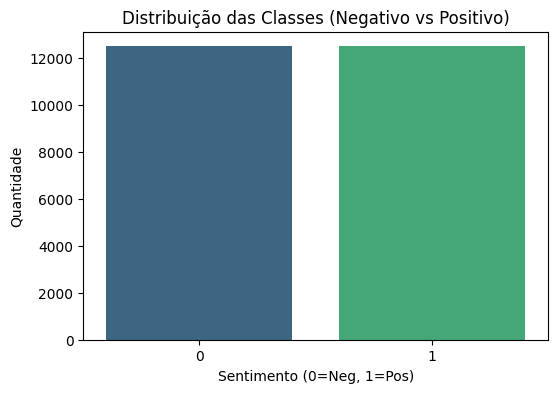

In [4]:
# --- PASSO B: ANÁLISE INICIAL E GRÁFICO ---

# 1. Contar quantos são positivos (1) e negativos (0)
# Isso verifica se os dados estão equilibrados
contagem = df_train['label'].value_counts()

print("Quantidade de avaliações por categoria:")
print(contagem)
print("\n(0 = Negativo, 1 = Positivo)")

# 2. Criar o Gráfico de Barras
plt.figure(figsize=(6, 4)) 
sns.countplot(x='label', data=df_train, palette='viridis') 
plt.title('Distribuição das Classes (Negativo vs Positivo)')
plt.xlabel('Sentimento (0=Neg, 1=Pos)')
plt.ylabel('Quantidade')
plt.show()

In [5]:
# --- PASSO C: LIMPEZA DOS DADOS (PRÉ-PROCESSAMENTO) ---
import re

# Função que vai limpar cada comentário
#def limpar_texto(texto):
    # 1. Converter tudo para minúsculas
#    texto = texto.lower()
    
    # 2. Remover tags HTML (ex: <br /> que aparece muito no IMDb)
#    texto = re.sub(r'<.*?>', '', texto)
    
    # 3. Remover pontuação e números (deixar só letras)
#    texto = re.sub(r'[^a-z\s]', '', texto)
    
    # 4. Remover stopwords (palavras inúteis como 'the', 'is', 'and')
#    stop_words = set(stopwords.words('english'))
#    palavras = texto.split()
#    palavras_limpas = [p for p in palavras if p not in stop_words]
    
#    return " ".join(palavras_limpas)

# --- PASSO C CORRIGIDO (Manter o 'não') ---
def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'<.*?>', '', texto)
    texto = re.sub(r'[^a-z\s]', '', texto)
    
    # Carregar stopwords
    stop_words = set(stopwords.words('english'))
    
    # Vamos tirar o 'not' e o 'no' da lista de proibidas
    stop_words.discard('not')
    stop_words.discard('no')
    # ------------------------
    
    palavras = texto.split()
    palavras_limpas = [p for p in palavras if p not in stop_words]
    return " ".join(palavras_limpas)
print("Começando a limpeza (pode demorar uns 30 segundos)...")

# Aplica a limpeza no Treino e no Teste
df_train['texto_limpo'] = df_train['text'].apply(limpar_texto)
df_test['texto_limpo'] = df_test['text'].apply(limpar_texto)

print("\n--- Limpeza Concluída! ---")
# Vamos comparar o Antes e Depois
print("ORIGINAL: ", df_train['text'][0][:80]) # Mostra os primeiros 80 caracteres
print("LIMPO:    ", df_train['texto_limpo'][0][:80])

Começando a limpeza (pode demorar uns 30 segundos)...

--- Limpeza Concluída! ---
ORIGINAL:  I rented I AM CURIOUS-YELLOW from my video store because of all the controversy 
LIMPO:     rented curiousyellow video store controversy surrounded first released also hear


Gerando a nuvem de palavras (pode levar alguns segundos)...


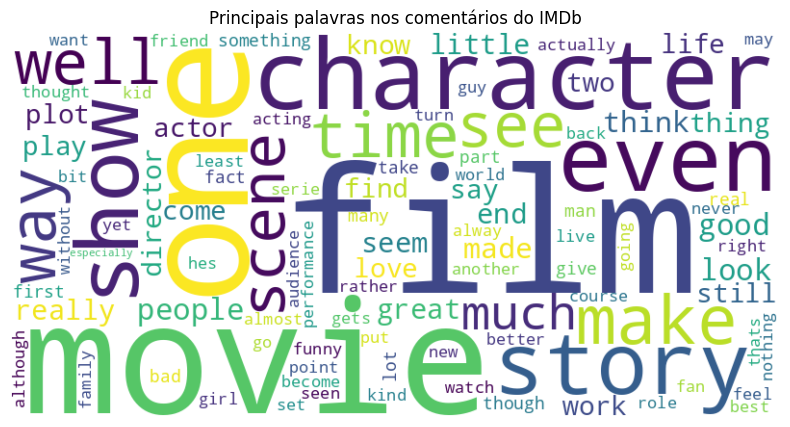

In [6]:
# --- PASSO D: VISUALIZAÇÃO (NUVEM DE PALAVRAS) ---
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Gerando a nuvem de palavras (pode levar alguns segundos)...")

# 1. Juntar todos os comentários limpos em um único texto gigante
texto_todo = " ".join(df_train['texto_limpo'])

# 2. Configurar e gerar a nuvem
# width/height = tamanho da imagem
# max_words = quantas palavras mostrar (limitei a 100 para ficar legível)
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white', 
                      max_words=100).generate(texto_todo)

# 3. Exibir o gráfico
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Remove os eixos (números laterais)
plt.title("Principais palavras nos comentários do IMDb")
plt.show()

In [7]:
# --- PASSO E: VETORIZAÇÃO (TF-IDF) ---
from sklearn.feature_extraction.text import TfidfVectorizer

print("Transformando textos em números (Vetorização)...")

# 1. Configurar o vetorizador
# max_features=5000: Vamos pegar apenas as 5.000 palavras mais importantes
# para não travar o computador (o dataset é grande!)
#tfidf = TfidfVectorizer(max_features=5000)  ---- exclui palavras únicas
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# 2. Aprender o vocabulário com o Treino e transformar
X_train = tfidf.fit_transform(df_train['texto_limpo'])

# 3. Apenas transformar o Teste (usando o vocabulário que aprendeu no treino)
X_test = tfidf.transform(df_test['texto_limpo'])

# 4. Separar as respostas (Labels)
y_train = df_train['label']
y_test = df_test['label']

print("\n--- Vetorização Concluída! ---")
print(f"Formato dos dados de Treino: {X_train.shape}")
print(f"Formato dos dados de Teste: {X_test.shape}")

Transformando textos em números (Vetorização)...

--- Vetorização Concluída! ---
Formato dos dados de Treino: (25000, 5000)
Formato dos dados de Teste: (25000, 5000)


Iniciando o treinamento...

Training Naive Bayes...
--- Resultado: Naive Bayes ---
Acurácia: 0.8521 (Acertou 85.21%)
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12500
           1       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



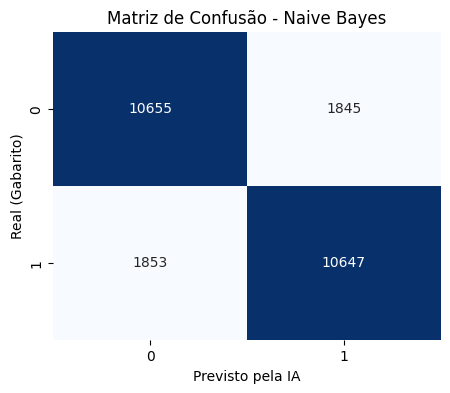


Training Regressão Logística...
--- Resultado: Regressão Logística ---
Acurácia: 0.8834 (Acertou 88.34%)
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     12500
           1       0.88      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



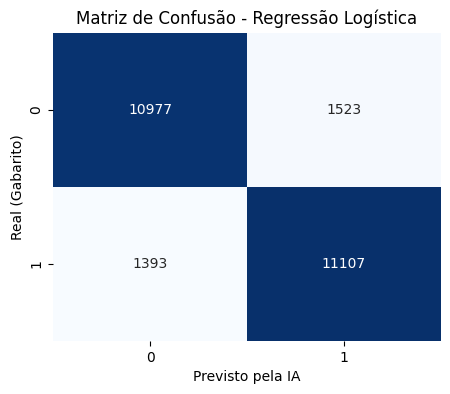


Training Random Forest...
--- Resultado: Random Forest ---
Acurácia: 0.8340 (Acertou 83.40%)
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     12500
           1       0.85      0.81      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



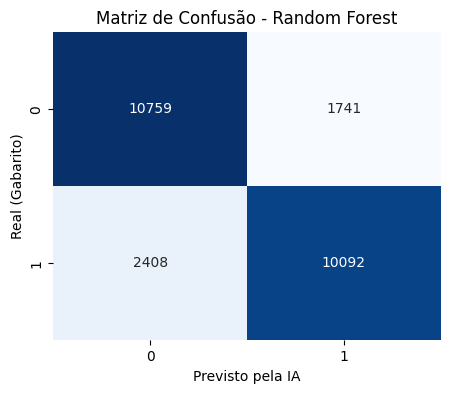


--- Processo Finalizado! ---


In [8]:
# --- PASSO F: TREINAMENTO E COMPARAÇÃO DE MODELOS ---
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Criando a lista de modelos que vamos testar
modelos = {
    "Naive Bayes": MultinomialNB(),
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1) 
    # n_estimators=50: usa 50 árvores (para não demorar demais)
}

print("Iniciando o treinamento...")

# 2. Loop para treinar e testar cada um
for nome, modelo in modelos.items():
    print(f"\nTraining {nome}...")
    
    # A) TREINAR (A IA estuda o material)
    modelo.fit(X_train, y_train)
    
    # B) TESTAR (A IA faz o teste)
    y_pred = modelo.predict(X_test)
    
    # C) AVALIAR
    acc = accuracy_score(y_test, y_pred)
    print(f"--- Resultado: {nome} ---")
    print(f"Acurácia: {acc:.4f} (Acertou {acc*100:.2f}%)")
    
    # Relatório detalhado (Precision, Recall, F1-Score - Exigência do PDF)
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred))
    
    # D) VISUALIZAR MATRIZ DE CONFUSÃO
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Matriz de Confusão - {nome}")
    plt.xlabel('Previsto pela IA')
    plt.ylabel('Real (Gabarito)')
    plt.show()

print("\n--- Processo Finalizado! ---")

In [9]:
# --- CÉLULA DE TESTE AO VIVO ---
# Vamos usar o melhor modelo (Regressão Logística) para testar frases na hora

def testar_frase(frase_nova):
    # 1. Limpar a frase (igual fizemos no treino)
    frase_limpa = limpar_texto(frase_nova)
    
    # 2. Transformar em números (usando o mesmo TF-IDF do treino)
    # Atenção: aqui usamos .transform(), NUNCA .fit_transform()
    frase_vetorizada = tfidf.transform([frase_limpa])
    
    # 3. Escolher o modelo campeão
    modelo_campeao = modelos["Regressão Logística"]
    
    # 4. Fazer a previsão
    previsao = modelo_campeao.predict(frase_vetorizada)[0]
    
    # 5. Mostrar o resultado organizado
    resultado = "POSITIVO (1) 👍" if previsao == 1 else "NEGATIVO (0) 👎"
    probabilidade = modelo_campeao.predict_proba(frase_vetorizada).max() * 100
    
    print(f"Frase Original: '{frase_nova}'")
    print(f"Sentimento: {resultado}")
    print(f"Certeza da IA: {probabilidade:.2f}%")
    print("-" * 30)

# Exemplos para deixar pronto:
print("--- TESTE RÁPIDO ---")
testar_frase("This movie is amazing and I loved it")
testar_frase("The plot was terrible and boring")
testar_frase("Eu sou um esquilo")

--- TESTE RÁPIDO ---
Frase Original: 'This movie is amazing and I loved it'
Sentimento: POSITIVO (1) 👍
Certeza da IA: 99.29%
------------------------------
Frase Original: 'The plot was terrible and boring'
Sentimento: NEGATIVO (0) 👎
Certeza da IA: 99.92%
------------------------------
Frase Original: 'Eu sou um esquilo'
Sentimento: POSITIVO (1) 👍
Certeza da IA: 50.25%
------------------------------


In [10]:
testar_frase("this is not a good day")
testar_frase("this is a good day")


Frase Original: 'this is not a good day'
Sentimento: NEGATIVO (0) 👎
Certeza da IA: 77.63%
------------------------------
Frase Original: 'this is a good day'
Sentimento: POSITIVO (1) 👍
Certeza da IA: 89.07%
------------------------------


In [11]:
# --- FUNÇÃO DE "RAIO-X" PARA APRESENTAÇÃO ---
import pandas as pd

def raio_x_do_modelo(frase_raw):
    print("="*60)
    print(f"🎥 ANALISANDO A FRASE: \"{frase_raw}\"")
    print("="*60)
    
    # PASSO 1: Limpeza Inicial
    # Vamos replicar o que a função limpar_texto faz, mas mostrando o meio do caminho
    texto_lower = frase_raw.lower()
    texto_sem_html = re.sub(r'<.*?>', '', texto_lower)
    texto_sem_pontuacao = re.sub(r'[^a-z\s]', '', texto_sem_html)
    
    print(f"\n1️⃣  PRÉ-PROCESSAMENTO (Limpeza):")
    print(f"   - Entrada:    {frase_raw}")
    print(f"   - Tratamento: {texto_sem_pontuacao}")
    
    # PASSO 2: Tokenização e Stopwords
    palavras = texto_sem_pontuacao.split()
    
    # Recuperando a lista de stopwords que usamos (garantindo que 'not' não está lá)
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')
    stop_words.discard('no')
    
    palavras_finais = [p for p in palavras if p not in stop_words]
    texto_final = " ".join(palavras_finais)
    
    print(f"\n2️⃣  TOKENIZAÇÃO E FILTRAGEM:")
    print(f"   - Tokens Brutos: {palavras}")
    print(f"   - Stopwords removidas: {[p for p in palavras if p in stop_words]}")
    print(f"   - O QUE A IA VAI LER: {palavras_finais}")
    
    # PASSO 3: Vetorização (Matemática)
    # Vamos ver quais números o TF-IDF atribuiu
    print(f"\n3️⃣  VETORIZAÇÃO (Transformando em Números):")
    vetor = tfidf.transform([texto_final])
    
    # Pegar os nomes das colunas (as palavras que o TF-IDF conhece)
    feature_names = tfidf.get_feature_names_out()
    
    # Mostrar apenas as palavras que existem no vocabulário da IA
    encontrou_algo = False
    df_vetor = pd.DataFrame(vetor.T.todense(), index=feature_names, columns=["peso"])
    df_vetor = df_vetor[df_vetor['peso'] > 0].sort_values(by='peso', ascending=False)
    
    if not df_vetor.empty:
        print("   A IA encontrou estas palavras no dicionário dela:")
        for palavra, row in df_vetor.iterrows():
            print(f"   - '{palavra}': Peso {row['peso']:.4f}")
    else:
        print("   ⚠️ Nenhuma dessas palavras estava no treinamento (Vocabulário desconhecido).")

    # PASSO 4: O Veredito
    modelo_campeao = modelos["Regressão Logística"] # Usando o melhor modelo
    probabilidade = modelo_campeao.predict_proba(vetor)[0]
    previsao = modelo_campeao.predict(vetor)[0]
    
    sentimento = "POSITIVO (1) 👍" if previsao == 1 else "NEGATIVO (0) 👎"
    
    print(f"\n4️⃣  VEREDITO FINAL:")
    print(f"   🔴 Chance de ser Negativo: {probabilidade[0]*100:.2f}%")
    print(f"   🟢 Chance de ser Positivo: {probabilidade[1]*100:.2f}%")
    print(f"   RESULTADO: {sentimento}")
    print("="*60)

# --- RODANDO O EXEMPLO ---
raio_x_do_modelo("The movie is not bad, actually it is amazing!")

🎥 ANALISANDO A FRASE: "The movie is not bad, actually it is amazing!"

1️⃣  PRÉ-PROCESSAMENTO (Limpeza):
   - Entrada:    The movie is not bad, actually it is amazing!
   - Tratamento: the movie is not bad actually it is amazing

2️⃣  TOKENIZAÇÃO E FILTRAGEM:
   - Tokens Brutos: ['the', 'movie', 'is', 'not', 'bad', 'actually', 'it', 'is', 'amazing']
   - Stopwords removidas: ['the', 'is', 'it', 'is']
   - O QUE A IA VAI LER: ['movie', 'not', 'bad', 'actually', 'amazing']

3️⃣  VETORIZAÇÃO (Transformando em Números):
   A IA encontrou estas palavras no dicionário dela:
   - 'not bad': Peso 0.5574
   - 'movie not': Peso 0.4802
   - 'amazing': Peso 0.4621
   - 'actually': Peso 0.3340
   - 'bad': Peso 0.2759
   - 'not': Peso 0.1706
   - 'movie': Peso 0.1686

4️⃣  VEREDITO FINAL:
   🔴 Chance de ser Negativo: 46.08%
   🟢 Chance de ser Positivo: 53.92%
   RESULTADO: POSITIVO (1) 👍


In [12]:
raio_x_do_modelo("T%his movie... is b.d!!!")

🎥 ANALISANDO A FRASE: "T%his movie... is b.d!!!"

1️⃣  PRÉ-PROCESSAMENTO (Limpeza):
   - Entrada:    T%his movie... is b.d!!!
   - Tratamento: this movie is bd

2️⃣  TOKENIZAÇÃO E FILTRAGEM:
   - Tokens Brutos: ['this', 'movie', 'is', 'bd']
   - Stopwords removidas: ['this', 'is']
   - O QUE A IA VAI LER: ['movie', 'bd']

3️⃣  VETORIZAÇÃO (Transformando em Números):
   A IA encontrou estas palavras no dicionário dela:
   - 'movie': Peso 1.0000

4️⃣  VEREDITO FINAL:
   🔴 Chance de ser Negativo: 65.57%
   🟢 Chance de ser Positivo: 34.43%
   RESULTADO: NEGATIVO (0) 👎


In [13]:
raio_x_do_modelo("")

🎥 ANALISANDO A FRASE: ""

1️⃣  PRÉ-PROCESSAMENTO (Limpeza):
   - Entrada:    
   - Tratamento: 

2️⃣  TOKENIZAÇÃO E FILTRAGEM:
   - Tokens Brutos: []
   - Stopwords removidas: []
   - O QUE A IA VAI LER: []

3️⃣  VETORIZAÇÃO (Transformando em Números):
   ⚠️ Nenhuma dessas palavras estava no treinamento (Vocabulário desconhecido).

4️⃣  VEREDITO FINAL:
   🔴 Chance de ser Negativo: 49.75%
   🟢 Chance de ser Positivo: 50.25%
   RESULTADO: POSITIVO (1) 👍


In [14]:
# --- RECUPERANDO A COLUNA PERDIDA (Limpeza de Dados) ---
import re
import nltk
from nltk.corpus import stopwords

# Garantir que temos as stopwords
nltk.download('stopwords')

def limpar_texto(texto):
    # 1. Minúsculas
    texto = texto.lower()
    # 2. Tira HTML
    texto = re.sub(r'<.*?>', '', texto)
    # 3. Tira pontuação (mantendo apenas letras e espaços)
    texto = re.sub(r'[^a-z\s]', '', texto)
    
    # 4. Stopwords (COM A CORREÇÃO DO 'NOT')
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not') # Importante: manter o não!
    stop_words.discard('no')
    
    palavras = texto.split()
    palavras_limpas = [p for p in palavras if p not in stop_words]
    
    return " ".join(palavras_limpas)

print("Refazendo a limpeza dos dados (Aguarde alguns segundos)...")

# AQUI É ONDE A MÁGICA ACONTECE: Criamos a coluna 'texto_limpo'
df_train['texto_limpo'] = df_train['text'].apply(limpar_texto)
df_test['texto_limpo'] = df_test['text'].apply(limpar_texto)

print("✅ Coluna 'texto_limpo' recriada com sucesso!")
print(df_train[['text', 'texto_limpo']].head(1))

Refazendo a limpeza dos dados (Aguarde alguns segundos)...


[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Coluna 'texto_limpo' recriada com sucesso!
                                                text  \
0  I rented I AM CURIOUS-YELLOW from my video sto...   

                                         texto_limpo  
0  rented curiousyellow video store controversy s...  


In [15]:
# --- BATERIA DE TESTES ATUALIZADA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import time

# Modelo fixo para comparação justa
modelo = LogisticRegression(max_iter=1000)

# Lista de configurações 
testes = [
    # --- BAG OF WORDS (BoW) ---
    {
        "Nome": "BoW - 1. Unigrama",
        "Vetorizador": CountVectorizer(ngram_range=(1, 1), max_features=5000)
    },
    {
        "Nome": "BoW - 2. Bigrama",
        "Vetorizador": CountVectorizer(ngram_range=(1, 2), max_features=5000)
    },
    {
        "Nome": "BoW - 3. Trigrama",
        "Vetorizador": CountVectorizer(ngram_range=(1, 3), max_features=5000)
    },
    {
        "Nome": "BoW - 4. Filtrado", 
        "Vetorizador": CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=0.7, max_features=5000)
    },
    
    # --- TF-IDF ---
    {
        "Nome": "TF-IDF - 1. Unigrama",
        "Vetorizador": TfidfVectorizer(ngram_range=(1, 1), max_features=5000)
    },
    {
        "Nome": "TF-IDF - 2. Bigrama",
        "Vetorizador": TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
    },
    {
        "Nome": "TF-IDF - 3. Trigrama",
        "Vetorizador": TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
    },
    {
        "Nome": "TF-IDF - 4. Otimizado", # (Sublinear + Bigrama)
        "Vetorizador": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True, min_df=5, max_features=5000)
    }
]

resultados = []

print(f"Iniciando comparação de {len(testes)} configurações...")
print("="*60)

for teste in testes:
    inicio = time.time()
    nome = teste["Nome"]
    vetorizador = teste["Vetorizador"]
    
    print(f"🔄 Testando: {nome}...")
    
    # 1. Vetorizar
    X_train_temp = vetorizador.fit_transform(df_train['texto_limpo'])
    X_test_temp = vetorizador.transform(df_test['texto_limpo'])
    
    # 2. Treinar
    modelo.fit(X_train_temp, y_train)
    
    # 3. Avaliar
    y_pred = modelo.predict(X_test_temp)
    acc = accuracy_score(y_test, y_pred)
    
    tempo = time.time() - inicio
    print(f"   ✅ Acurácia: {acc:.4f} (Tempo: {tempo:.1f}s)")
    
    resultados.append({
        "Configuração": nome,
        "Acurácia": acc,
        "Tempo (s)": round(tempo, 1)
    })

print("="*60)
df_resultados = pd.DataFrame(resultados).sort_values(by="Acurácia", ascending=False)
display(df_resultados)

Iniciando comparação de 8 configurações...
🔄 Testando: BoW - 1. Unigrama...
   ✅ Acurácia: 0.8485 (Tempo: 7.2s)
🔄 Testando: BoW - 2. Bigrama...
   ✅ Acurácia: 0.8544 (Tempo: 22.8s)
🔄 Testando: BoW - 3. Trigrama...
   ✅ Acurácia: 0.8545 (Tempo: 39.1s)
🔄 Testando: BoW - 4. Filtrado...
   ✅ Acurácia: 0.8481 (Tempo: 6.6s)
🔄 Testando: TF-IDF - 1. Unigrama...
   ✅ Acurácia: 0.8797 (Tempo: 5.0s)
🔄 Testando: TF-IDF - 2. Bigrama...
   ✅ Acurácia: 0.8834 (Tempo: 19.7s)
🔄 Testando: TF-IDF - 3. Trigrama...
   ✅ Acurácia: 0.8837 (Tempo: 38.2s)
🔄 Testando: TF-IDF - 4. Otimizado...
   ✅ Acurácia: 0.8867 (Tempo: 19.2s)


,Configuração,Acurácia,Tempo (s)
7,TF-IDF - 4. Otimizado,0.88668,19.2
6,TF-IDF - 3. Trigrama,0.88372,38.2
5,TF-IDF - 2. Bigrama,0.88336,19.7
4,TF-IDF - 1. Unigrama,0.87972,5.0
2,BoW - 3. Trigrama,0.85452,39.1
1,BoW - 2. Bigrama,0.85436,22.8
0,BoW - 1. Unigrama,0.84848,7.2
3,BoW - 4. Filtrado,0.84812,6.6


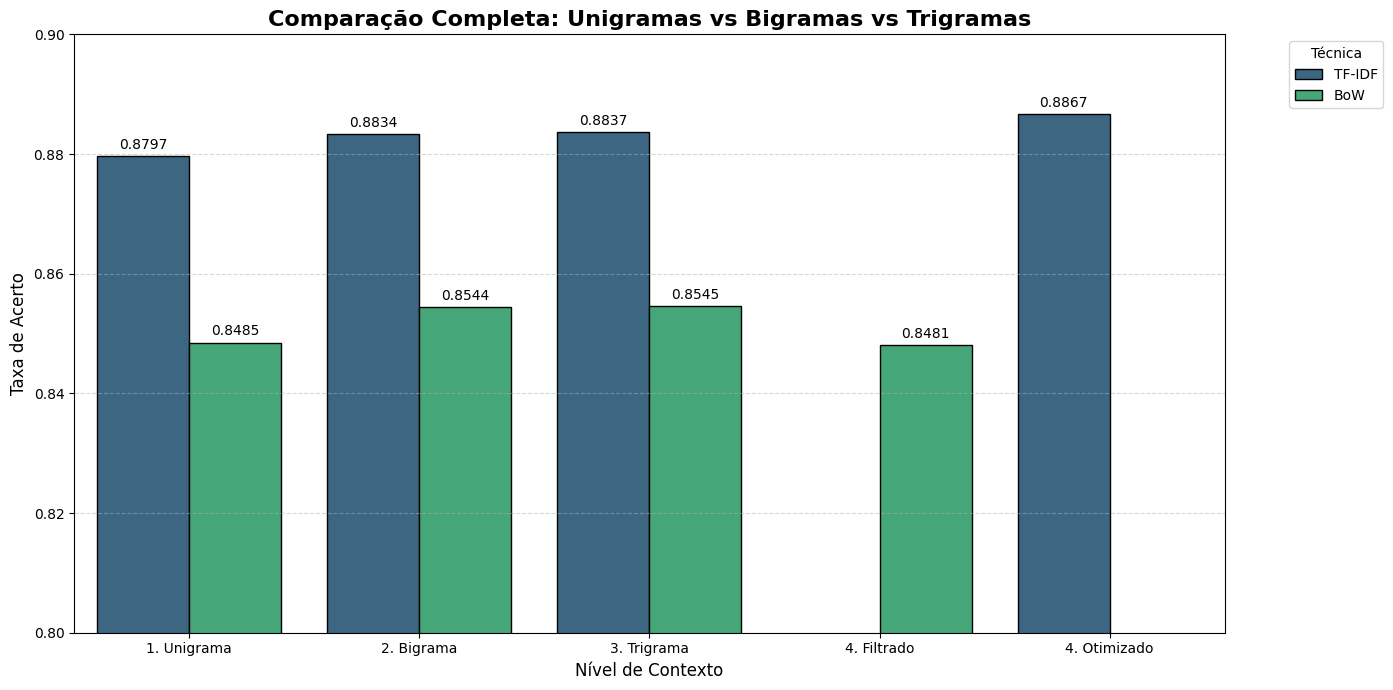

In [16]:
# --- GRÁFICO FINAL COMPLETO 
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparando os dados
# Separando "BoW" de "1. Unigrama"
df_resultados['Modelo'] = df_resultados['Configuração'].apply(lambda x: x.split(' - ')[0])
df_resultados['Tipo'] = df_resultados['Configuração'].apply(lambda x: x.split(' - ')[1])

# Ordem lógica para o gráfico (Unigrama -> Bigrama -> Trigrama -> Otimizado)
ordem_tipos = ["1. Unigrama", "2. Bigrama", "3. Trigrama", "4. Filtrado", "4. Otimizado"]

plt.figure(figsize=(14, 7)) 

# 2. Plotando
grafico = sns.barplot(
    data=df_resultados, 
    x="Tipo", 
    y="Acurácia", 
    hue="Modelo", 
    palette="viridis",
    edgecolor="black",
    order=sorted(df_resultados['Tipo'].unique()) # Garante a ordem: 1, 2, 3...
)

# 3. Ajustes Visuais e Proporção
plt.title("Comparação Completa: Unigramas vs Bigramas vs Trigramas", fontsize=16, fontweight='bold')
plt.xlabel("Nível de Contexto", fontsize=12)
plt.ylabel("Taxa de Acerto", fontsize=12)

# --- AJUSTE DE ALTURA ---
plt.ylim(0.80, 0.90) 

plt.legend(title="Técnica", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Rótulos
for container in grafico.containers:
    grafico.bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()